# Geo-Data Extraction Using ThinkingMachine Codes and QGIS &ndash; An Application for Impact Evaluation and Poverty Mapping 

This notebook is a sister notebook to `poverty_mapping_pppp.ipynb`, which explores practical machine learning approaches for wealth and poverty mapping. Here, we construct the extensive dataset required for the analysis performed therein. Please refer to `poverty_mapping_pppp.ipynb` for a complete description of this project. 

In [1]:
# General
import os
import re
from dotenv import load_dotenv
from pathlib import Path
import gc
import time
import pickle
import math
from pathlib import Path
from loguru import logger

# Mathematical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ThinkingMachine utilities
from povertymapping import dhs, nightlights, feature_engineering
from povertymapping.osm import OsmDataManager, add_osm_poi_features, add_osm_road_features
from povertymapping.iso3 import get_region_name
from povertymapping.rollout_grids import get_region_filtered_bingtile_grids, compute_raster_stats
from povertymapping.geoboundaries import get_geoboundaries
from povertymapping.hrsl import get_hrsl_file, get_unzipped_hrslfile
from geowrangler.grids import BingTileGridGenerator
import geowrangler.raster_zonal_stats as rzs
import geowrangler.spatialjoin_highest_intersection as sjhi

# Google Earth Engine and mapping
import ee
import geemap
import geopandas as gpd

# Stats/Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Deep learning
from torchvision import datasets, models, transforms

# Mapping and images
import rasterio

## Table of Contents

1. [Overview](#Overview)
2. [Data](#Data)
4. [Train Label - DHS](#Train-Label---DHS)
5. [Train Features](#train-Features)
    1. [OOKLA and Nightlight](#OOKLA-and-Nightlight)
    2. [OSM](#OSM)
    3. [Daytime Satellite Images](#Daytime-Satellite-Images)
4. [Prediction Features](#Prediction-Features)
    1. [Generate Grids](#Generate-Grids)
    2. [Grid Features](#Grid-Features)

## Overview

In this notebook, we utilize ThinkingMachines' open-source code (with minor adaptations to fit our needs) to gather and organize geo-data such as nightlight, internet speed, mobile data usage, proximity to amenities, as well as the target of the predictive model, the wealth index according to the Demographic and Heath Survey (DHS). QGIS is used to gather the daytime satellite images for the computer vision component of the model. All data used in this project are open-source, although some may not be free for us to share. Where appropriate, instructions or links for accessing these datasets will be provided.

Kudos to ThinkingMachines for their awesome code and contributions to public good. To install the required ThinkingMachine codes, we can run the following

`!pip install git+https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git`

As the ThinkingMachines codes appear to rely on older versions of certain packages, we recommend isolating the environment used for this notebook from the environment used for the other notebooks.

Please refer to `requirements_TM.txt` for the installation requirements for this notebook.

## Data

1. __DHS Wealth Index__ - The DHS provides measurements of well-being across multiple dimensions for demographic studies, including wealth, health conditions. For this project, we focus on the wealth index as a proxy for poverty levels.

2. __Nightlight__ - Nightlight information from satellite images has long been used by researchers for extracting information about human activity. Here, we use the degree of illumination as a predictor for economic development. This is obtained using the Earth Observation Group (EOG) API.

3. __Daytime satellite images__ - There has been growing interest in the use of computer vision for satellite images to conduct remote census and poverty mapping. Here we use collect these images using QGIS.

4. __Internet speed and mobile data__ - Internet speed and mobile data usage are also good indicators of development, and can be obtained from OOKLA.

5. __Amenities__ - The presence of amenities such as markets, schools and roads point to regional development. We extract these from OpenStreetMap (OSM).

## Train Label - DHS

We begin by extracting wealth information from the Demographic and Health Survey (DHS) dataset, which is given as the Wealth Index. This will be our label (target) for subsequent model training. In view of the large sizes of the datasets involved, the ThinkingMachines code used below minimizes network overhead by caching downloaded data. We set up a default cache following ThinkingMachines code requirements.

In [2]:
# Directory setup
DEFAULT_CACHE_DIR = "~/.geowrangler"
home_dir = os.path.expanduser('~')

We can now extract the DHS values for 2022. Instructions for setting up an account for downloading the DHS data can be found [here](https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping). The downloaded data is assumed to be stored in `data/dhs/`. The `dhs.generate_dhs_cluster_level_data` function is used to generate square tiles representing the geographic locations of the DHS data, i.e. the location and geographic extents of each DHS survey data point.

In [3]:
# Set up for extracting relevant data from DHS
COUNTRY_CODE = "ph"                                                    # Philippines as country of interest in this study
DHS_LABEL_COL = "Wealth Index"                                         # Column name as labels for model training
OUTPUT_LABEL_COL = "Wealth_Index"
TILE_SIZE_KM = 2.4                                                     # Tile size as geographic extent for each DHS cluster (unit)

# Paths for DHS material in 2022
DHS_HOUSEHOLD_DTA_PATH_2022 = "data/dhs/ph/PHHR82DT/PHHR82FL.DTA"      # Survey data in dta (stata) format, 2022
DHS_GEOGRAPHIC_SHP_PATH_2022 = "data/dhs/ph/PHGE81FL/PHGE81FL.shp"     # Geographic data (shapefile), 2022

dhs_gdf_2022 = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH_2022,
    DHS_GEOGRAPHIC_SHP_PATH_2022,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

# ThinkingMachines approach suggested minmaxscaler for wealth index at this stage. Here, we reserve this scaling until after train test split is performed.
country_data_2022 = dhs_gdf_2022.copy()
country_data_2022.rename(columns={DHS_LABEL_COL:OUTPUT_LABEL_COL}, inplace=True)
labels_2022 = country_data_2022[['DHSCLUST',OUTPUT_LABEL_COL]]
labels_2022 = labels_2022.set_index('DHSCLUST')

The resulting dataframe `country_data_2022` is a geopandas dataframe, with survey information from each location, including the coordinates of the locations themselves.

In [4]:
country_data_2022.head()

,DHSCLUST,Wealth_Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-121269.250000,PH202200000001,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.716158,122.116863,9999.0,30.0,WGS84,"POLYGON ((122.106 6.72695, 122.12773 6.72695, ..."
1,2,-69178.739130,PH202200000002,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,U,6.654423,122.130171,9999.0,11.0,WGS84,"POLYGON ((122.11931 6.66521, 122.14104 6.66521..."
2,3,-130489.000000,PH202200000003,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.510455,122.122877,9999.0,420.0,WGS84,"POLYGON ((122.11202 6.52125, 122.13374 6.52125..."
3,4,-190052.888889,PH202200000004,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.474001,122.058552,9999.0,181.0,WGS84,"POLYGON ((122.04769 6.48479, 122.06941 6.48479..."
4,5,-108371.035714,PH202200000005,PH,2022.0,RP,NULL,NULL,NULL,NULL,...,15.0,BARMM - Bangsamoro Autonomous Region in Muslim...,GPS,R,6.525690,121.873975,9999.0,1.0,WGS84,"POLYGON ((121.86311 6.53648, 121.88484 6.53648..."


The surveyed locations for 2022 are shown by the blue dots in the interactive map below.

In [5]:
country_data_2022.explore()

In [ ]:
country_data_2022.plot()

## Train Features

Next, we retrieve the following features used for model training and later prediction:
1. internet speed and mobile usage data from OOKLA;
2. satellite nightlight data from Earth Observation Group (EOG);
3. map data from OpenStreetMap, e.g. distance to amenities, road structure, etc;
4. daytime satellite images

For model training on the 2022 DHS Wealth Index, we look at data from 2022. For prediction in other years, we gather the same data from 2020 to 2023.

#### OOKLA and Nightlight

We extract nightlight data from Earth Observation Group (EOG), as well as internet speed and mobile data usage from OOKLA. An EOG account is required for downloading the nightlight dataset using ThinkingMachine codes. The instructions for registering an account is provided [here](https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping).

The following cell obtains the access token for API access to the EOG server. The `.env` user name and password are assumed to be placed in `.env` in the home directory.

In [6]:
# Log-in using EOG credentials for nightlight data
env_path = Path.home() / '.env'
load_dotenv(dotenv_path=env_path)
username = os.getenv("EOG_USER")
username = username if username is not None else input("Username?")
password = os.getenv("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")
access_token = nightlights.get_eog_access_token(username, password, save_token=True) # set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token

2024-09-11 19:15:04.723 | INFO     | povertymapping.nightlights:get_eog_access_token:42 - Saving access_token to /home/tfc/.eog_creds/eog_access_token.txt
2024-09-11 19:15:04.732 | INFO     | povertymapping.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


The `feature_engineering.generate_features` function below automatically downloads and caches nightlight, OOKLA, as well as OpenStreetMap (OSM) data. The corresponding values at the square tiles given in `country_data_2022` earlier are returned by the function.

__OSM remark__: Note that the code downloads only the latest OSM data for use. For our considered use case, we may be interested in using OSM data from past years instead. Therefore, we use the code below only to retrieve nightlight and OOKLA data, and ignore the accompanying OSM data (for now). OSM will be considered at a later sub-section.

In [7]:
# Create features dataframe using generate_features module
ookla_nightlight_2022 = feature_engineering.generate_features(
    country_data_2022,
    country_osm="philippines",
    ookla_year=2022,                       # OOKLA data only available from 2019
    nightlights_year=2022,
    scale=False,
    features_only=True
)

# Keep only OOKLA and nightlight features
ookla_nightlight_features = [col for col in ookla_nightlight_2022.columns if ('fixed' in col) | ('mobile' in col) | ('rad' in col)]
ookla_nightlight_2022 = ookla_nightlight_2022[ookla_nightlight_features]
ookla_nightlight_2022['DHSCLUST'] = country_data_2022['DHSCLUST']
ookla_nightlight_2022 = ookla_nightlight_2022.set_index('DHSCLUST')

2024-09-11 19:16:47.742 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-09-11 19:16:47.742 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2024-09-11 19:16:48.727 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-09-11 19:16:48.728 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2024-09-11 19:16:54.848 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2024-09-11 19:16:54.848 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/tfc/.geowrangler/ookla/processed/966bd4bda0c54a77

The process above can be easily repeated to download and cache data from different years. For our needs, we download data from 2020 to 2023. This is not shown here.

#### OSM

As mentioned earlier, the ThinkingMachine codes download only the latest OSM data and does not offer the option of download for specific years. We circumvent this by downloading directly from dump files [here](https://download.geofabrik.de/asia/). We download the zip files and extract the shapefiles to `.geowrangler/osm/philippines_XXXX`, where `XXXX` refer to the year of interest.

__Remark__: To download the shapefiles for the Philippines in 2024, download the `philippines-240901-free.shp.zip` file from the website given above, where `24` refers to the year of the dump file.

In [8]:
# Show all 2022 OSM shapefiles available
osm_datapath_2022 = os.path.join(home_dir,'.geowrangler/osm/','philippines_2022')
sorted([f for f in os.listdir(osm_datapath_2022) if f.endswith('.shp')])

['gis_osm_buildings_a_free_1.shp',
 'gis_osm_landuse_a_free_1.shp',
 'gis_osm_natural_a_free_1.shp',
 'gis_osm_natural_free_1.shp',
 'gis_osm_places_a_free_1.shp',
 'gis_osm_places_free_1.shp',
 'gis_osm_pofw_a_free_1.shp',
 'gis_osm_pofw_free_1.shp',
 'gis_osm_pois_a_free_1.shp',
 'gis_osm_pois_free_1.shp',
 'gis_osm_railways_free_1.shp',
 'gis_osm_roads_free_1.shp',
 'gis_osm_traffic_a_free_1.shp',
 'gis_osm_traffic_free_1.shp',
 'gis_osm_transport_a_free_1.shp',
 'gis_osm_transport_free_1.shp',
 'gis_osm_water_a_free_1.shp',
 'gis_osm_waterways_free_1.shp']

As shown above, different shapefiles for different geographical features are available. We check the features contained in each shapefile below.

In [9]:
# Show features contained in each shapefile
all_files = sorted([f for f in os.listdir(osm_datapath_2022) if f.endswith('.shp')])
for f in all_files:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print(f)
    filepath = os.path.join(osm_datapath_2022,f)
    gdf = gpd.read_file(filepath)
    print(gdf.fclass.unique())
    print()

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_buildings_a_free_1.shp
['building']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_landuse_a_free_1.shp
['retail' 'park' 'grass' 'cemetery' 'industrial' 'commercial'
 'residential' 'forest' 'recreation_ground' 'farmland' 'scrub' 'military'
 'nature_reserve' 'meadow' 'quarry' 'farmyard' 'heath' 'allotments'
 'orchard' 'vineyard']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_natural_a_free_1.shp
['beach' 'cliff' 'spring' 'tree' 'cave_entrance']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_natural_free_1.shp
['tree' 'cave_entrance' 'peak' 'spring' 'cliff' 'beach' 'volcano']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_places_a_free_1.shp
['island' 'village' 'hamlet' 'locality' 'farm' 'town' 'city' 'suburb']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_places_free_1.shp
['suburb' 'city' 'town' 'hamlet' 'village' 'national_capital' 'island'
 'locality' 'farm' 'region' 'county']

~~~~~~~~~~~~~~~~~~~~~~~~~~
gis_osm_pofw_a_free_1.shp
['christian' 'christian_catholic' 'jewish' 'christian_evangelical'
 'bud

Based on the features above, we select the following shapefiles to include in our analysis:
- `gis_osm_pois_free_1.shp` for points of interest
- `gis_osm_transport_free_1.shp` and `gis_osm_traffic_free_1.shp` for transport related amenities

This is a departure from the original features selected by ThinkingMachine, which were all extracted in `gis_osm_pois_free_1.shp` and hardcoded in the `osm.add_osm_poi_features` function as such. For simplicity and to avoid making changes to the ThinkingMachines code, we include transport related amenities into the points of interest shapefile, i.e. `gis_osm_pois_free_1.shp`.

In [11]:
# Combine shapefiles to replace gis_osm_pois_free_1.shp
required_shapefiles = ['gis_osm_pois_free_1.shp',             # Shapefiles to combine
                       'gis_osm_transport_free_1.shp',
                       'gis_osm_traffic_free_1.shp']
gdfs = [gpd.read_file(os.path.join(osm_datapath_2022,shapefile)) for shapefile in required_shapefiles]
gdfs[0].to_file(os.path.join(osm_datapath_2022,'gis_osm_pois_free_1_original.shp'))           # Make backup of original gis_osm_pois_free_1.shp file
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
combined_gdf.to_file(os.path.join(osm_datapath_2022,'gis_osm_pois_free_1.shp'))               # Replace original file

The two cells above can similarly be used to augment the points of interest shapefiles from the other years, i.e. 2020 to 2023. This is not shown here.

We can now proceed to generate the required points of interest features for the dataset. The `OSM.add_osm_poi_features` function is used for this.

__Remark__: The original code specifies `country_osm = "philippines"` for the default (latest) OSM data for the Philippines. We direct the code to extract data from 2022 by using `country_osm = "philippines_2022"`, where `philippines_2022` is the folder name in the `.geowrangler/osm/` cache directory.

In [22]:
# Instantiate data managers for OSM
osm_data_manager = OsmDataManager(cache_dir=DEFAULT_CACHE_DIR)
country_osm = "philippines_2022"

# Get OSM point features
OSM_poi_features = add_osm_poi_features(
    country_data_2022, country_osm, osm_data_manager, poi_types = combined_gdf.fclass.unique(), use_cache=True
)
OSM_poi_features = OSM_poi_features[[col for col in OSM_poi_features.columns if not (col in country_data_2022.columns)]]
OSM_poi_features['DHSCLUST'] = country_data_2022['DHSCLUST']
OSM_poi_features = OSM_poi_features.set_index('DHSCLUST')

2024-08-27 12:02:25.694 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-27 12:02:25.694 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_pois_free_1.shp


Next, we include road related features using `osm.add_osm_road_features` function.

In [23]:
# Get OSM road features
OSM_road_features = add_osm_road_features(
    country_data_2022, country_osm, osm_data_manager, use_cache=True
)
OSM_road_features = OSM_road_features[[col for col in OSM_road_features.columns if not (col in country_data_2022.columns)]]
OSM_road_features['DHSCLUST'] = country_data_2022['DHSCLUST']
OSM_road_features = OSM_road_features.set_index('DHSCLUST')

2024-08-27 12:02:30.078 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-27 12:02:30.079 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_roads_free_1.shp


#### Daytime Satellite Images

There are multiple sources for daytime satellite images. We prefer open-source data that require minimal GIS expertise and pre-processing, and has historical record over multiple years. Different approaches were explored in this project:
1. Downloading Sentinel-2 (harmonized) images from [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) via `geemap` package - good quality data at 10m resolution, but requires moderate pre-processing efforts including:
   
    a. Removal of cloud covers
    
    b. Histogram matching or other techniques to match band values across different image tiles and years
    
2. Downloading high resolution image from Google Maps - using [Google Maps Static API] for high resolution images at 1m resolution (https://developers.google.com/maps/documentation/maps-static/overview) `googlemaps`. However, this approach is not free and only the latest satellite image is available (i.e. no historical records or data dumps available).  Note that this is the approach taken by ThinkingMachines in their [repo](https://github.com/thinkingmachines/ph-poverty-mapping/tree/master).
3. High quality (16-bit) Sentinel-2 images from EOX - preprocessed Sentinel 2 images to remove cloud cover, with images from multiple years available, but is not free.
4. Moderate quality (8-bit) Sentinel-2 images from EOX - via Web Map Service (WMS), similarly preprocessed to remove cloud, and is freely available, easily accessible through GIS softwares.

Here, we use __approach 4__, in view of the consistency in data quality and format across the years, and cost considerations. [QGIS](https://www.qgis.org/), an open-source GIS software, will be used to access the EOX furnished cloudless Sentinel-2 images.

The geopandas dataframe above `country_data_2022` contains the geometries of the required images for training, giving their location as well as extent (2.4km x 2.4km corresponding to 240 x 240 pixels). We export these geometries as a vector shapefile, which will be used in QGIS later for image extraction. The EPSG:4326 CRS is used here without any reprojection for simplicity.

In [ ]:
shape_path = '/data/daysat/2022/dhs_shapes'
shape_name = 'phil_2022_extents_epsg4326.shp'
shape_file = os.path.join(shape_path,shape_name)
country_data_2022.to_file(shape_file)

QGIS comes with the Python console pre-installed. We can run the helper script `qgis_export_wms_as_tif_tiles.py` in the helpers folder in the QGIS Python console to extract the required images. The script is reproduced below for reference. Note that we assume a 2.4 by 2.4km extent, giving a 240 by 240 pixel image. After creating the shape files (cell above), the following steps are taken:

1. Open QGIS
2. Load the shapefile `phil_2022_extents_epsg4326.shp`
3. Load the WMS raster directly in QGIS. The 2022 file is called "Sentinel-2 cloudless layer for 2022 by EOX - 4326"
4. Save a copy of the code as a python script in a convenient location.
5. Change the input reference in the python code accordingly (under `## INPUT`) to reflect these layer names.
6. Open the python console (plugin menu) and run the code.

```
import os
from qgis.core import QgsProject, QgsMapSettings, QgsMapRendererParallelJob, QgsMapLayerType
from PyQt5.QtCore import QSize
import time

'''
Automates image export from QGIS for EOX cloudless Sentinel-2 map.
Note: Clip raster by mask layer does not work for WMS maps
'''

## INPUT
daysat_folder = "data/daysat/2022/"          # Define output folder. The data folder here resides in the project repo. Amend as needed.
shape_name = "phil_2022_extents_epsg4326"    # Define shape name for clipping image tiles from map
map_name = "Sentinel-2 cloudless layer for 2022 by EOX - 4326"      # Define name of Sentinel-2 map layer loaded in QGIS

# Create output folder if it does not exist
if not os.path.exists(daysat_folder):
    os.makedirs(daysat_folder)

# Load the vector layer defining extents
extent_layer = QgsProject.instance().mapLayersByName(shape_name)[0]

# Load raster layer of EOX cloudless Sentinel-2 basemap via WMS
sentinel2_layer = QgsProject.instance().mapLayersByName(map_name)[0]

# Prepare the QGIS map settings
def setup_map_settings():
    map_settings = QgsMapSettings()
    map_settings.setLayers([sentinel2_layer])
    map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels
    return map_settings

map_settings = setup_map_settings()

def export_feature(feature):
    try:
        geom = feature.geometry()
        extent = geom.boundingBox()
        map_settings.setExtent(extent)

        output_file = os.path.join(daysat_folder, f"map_{feature.id()}.tif")

        # Adjust output size based on extent
        map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels

        # Render the map
        render_job = QgsMapRendererParallelJob(map_settings)
        render_job.start()
        render_job.waitForFinished()

        image = render_job.renderedImage()
        image.save(output_file,"tif")

#         print(f"Exported {output_file}")
    except Exception as e:
        print(f"Failed to export feature {feature.id()}: {e}")

# Process each feature sequentially
for i,feature in enumerate(extent_layer.getFeatures()):
    export_feature(feature)
    if i%100==0:
        print(f'At image {i} of len(extent_layer.getFeatures())')
        time.sleep(5)

print("Export completed.")
```

The resulting images have four bands, with the first three corresponding to R, G, B. We keep only these first three bands using the code below.

In [23]:
# Keep only RGB bands
original_daysat_folder = "data/daysat/2022/"
temp_daysat_folder = "data/daysat/2022_temp/"
original_tifs = [f for f in os.listdir(original_daysat_folder) if f.lower().endswith('.tif')]

# Create the directory if it doesn't exist
os.makedirs(temp_daysat_folder, exist_ok=True)

# Iterate through each file and corresponding axis
for tif in original_tifs:
    original_tif_path = os.path.join(original_daysat_folder, tif)
    temp_tif_path = os.path.join(temp_daysat_folder, tif)

    with rasterio.open(original_tif_path) as src:
        # Check if the file has at least 3 bands
        if src.count < 3:
            raise ValueError("The file has fewer than 3 bands.")
    
        bands_data = src.read([1, 2, 3])                      # Read the first 3 bands
        profile = src.profile                                 # Write the first 3 bands to a temporary file
        profile.update(count=3)                               # Update the profile to only have 3 bands
        
        with rasterio.open(temp_tif_path, 'w', **profile) as dst:
            dst.write(bands_data)

    # Replace the original file with the new file
    os.replace(temp_tif_path,original_tif_path)

Some sample images extracted this way are show below

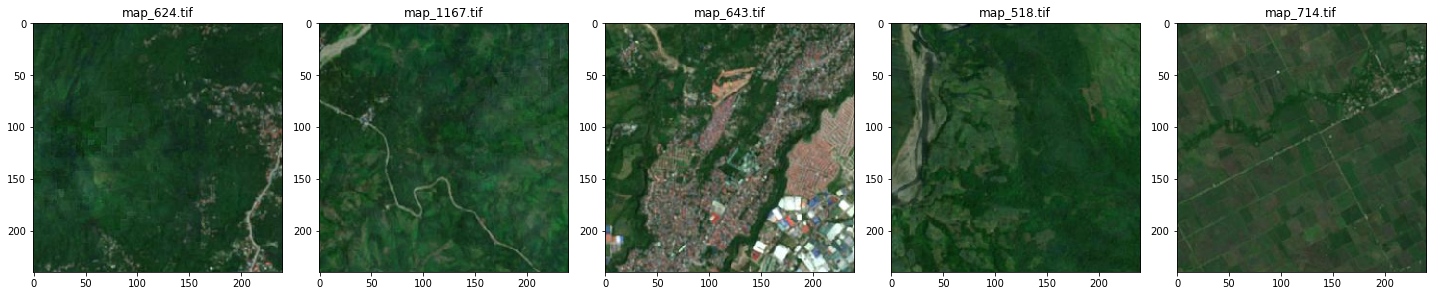

In [24]:
# Sample 5 tif images to display
daysat_folder = "data/daysat/2022/"
all_tif_files = [f for f in os.listdir(daysat_folder) if f.lower().endswith('.tif')]
sampled_files = random.sample(all_tif_files, 5)
sampled_file_paths = [os.path.join(daysat_folder, f) for f in sampled_files]

# Plot
fig, axes = plt.subplots(1,5,figsize=(20, 5))

# Iterate through each file and corresponding axis
for ax, tif_file in zip(axes, sampled_file_paths):
    with rasterio.open(tif_file) as src:
        bands = [src.read(i) for i in range(1, src.count + 1)]
        rgb_image = np.stack([bands[0], bands[1], bands[2]], axis=-1)  # RGB
        ax.imshow(rgb_image)
        ax.set_title(tif_file.split('/')[-1])
        
fig.tight_layout()

This concludes the data requirements for model training.

## Prediction Features

For model training, we retrieved training data on grid cells corresponding to locations where DHS is conducted. Eventually, the trained model is to be used for prediction on the entire country, not just these DHS locations. This means that the corresponding features and satellite images should be collected for covering the entire country. We demonstrate this process for 2022 below. The same process can be used to get the required data from other years.

### Generate Grids

Similar to the generation of DHS geographic square tiles corresponding to DHS locations, we need to generate tiles for the entire country. This grid of tiles is generated here.

In the ThinkingMachines approach, the `povertymapping.rollout_grids.get_region_filtered_bingtile_grids` function is used to get the grid cells required. This function leverages the High Resolution Settlement Layer (HRSL) to select only locations where human settlements are found. We adapt the code as `get_admin_grids_gdf` below to allow finer control over the HRSL data to use, and opt for the 2020 HRSL data.

In [2]:
def get_admin_grids_gdf(
    region,admin_lvl,quadkey_lvl,use_cache,
    cache_dir,assign_grid_admin_area,
    metric_crs,extra_args,
    group_col,max_batch_size,
    n_workers,hrsl_country,
    hrsl_year, demographic,filetype):
    '''
    Adapted from povertymapping.rollout_grids.get_region_filtered_bingtile_grids, adding
    option for year of HRSL data to take
    '''
    directory = Path(os.path.expanduser(cache_dir)) / "quadkey_grids"
    directory.mkdir(parents=True, exist_ok=True)

    if extra_args is None:
        extra_args = dict(nodata=np.nan)

    directory.mkdir(parents=True, exist_ok=True)

    unfiltered_grids_file = (
        directory / f"{region}_{quadkey_lvl}_{admin_lvl}_admin_grids.geojson"
    )

    admin_grids_file = (
        directory
        / f"{region}_{quadkey_lvl}_{admin_lvl}_populated_admin_grids_{hrsl_year}.geojson"
    )

    if admin_grids_file.exists() and use_cache:
        logger.info(f"Loading cached grids file {admin_grids_file}")
        admin_grids_gdf = gpd.read_file(admin_grids_file)
        return admin_grids_gdf

    if not admin_grids_file.exists():
        logger.info(
            f"No cached grids file found. Generating grids file :{admin_grids_file}"
        )
    else:
        logger.info(f"Regenerating grids file {admin_grids_file}")

    if unfiltered_grids_file.exists():
        logger.info(
            f"Loading existing grids file {unfiltered_grids_file} and skip gridding"
        )
        admin_grids_gdf = gpd.read_file(unfiltered_grids_file)
        grid_count = len(admin_grids_gdf)
        logger.info(
            f"Loaded {grid_count} grids for region {region} and admin level {admin_lvl} at quadkey level {quadkey_lvl}"
        )
    else:
        logger.debug(
            f"Loading boundaries for region {region} and admin level {admin_lvl}"
        )

        admin_area_file = get_geoboundaries(region, adm=admin_lvl)
        admin_gdf = gpd.read_file(admin_area_file)

        logger.info(
            f"Generating grids for region {region} and admin level {admin_lvl} at quadkey level {quadkey_lvl} for HRSL year {hrsl_year}"
        )

        grid_gen = BingTileGridGenerator(quadkey_lvl)
        admin_grids_gdf = grid_gen.generate_grid_join(admin_gdf)
        grid_count = len(admin_grids_gdf)
        logger.info(
            f"Generated {grid_count} grids for region {region} and admin level {admin_lvl} at quadkey level {quadkey_lvl}"
        )

        # use a metric crs (e.g. epsg:3857) for computing overlaps
        if assign_grid_admin_area:
            logger.info(f"Assigning grids to admin areas using metric crs {metric_crs}")
            admin_grids_gdf = sjhi.get_highest_intersection(
                admin_grids_gdf, admin_gdf, metric_crs
            )

    logger.info(f"Getting {region} population data for filtering grids")

    unzipped_hrslfile = get_unzipped_hrslfile(
        region,
        year=hrsl_year,
        filetype=filetype,
        demographic=demographic,
        cache_dir=cache_dir,
    )

    hrsl_pop_file = Path(os.path.expanduser(cache_dir)) / f"hrsl/{hrsl_country}_{demographic}_{hrsl_year}.tif"

    logger.info("Computing population zonal stats per grid")
    admin_grids_gdf = compute_raster_stats(
        admin_grids_gdf,
        hrsl_pop_file,
        aggregation=dict(column="population", output="pop_count", func="sum"),
        extra_args=extra_args,
        group_col=group_col,
        max_batch_size=max_batch_size,
        n_workers=n_workers,
    )

    logger.info("Filtering unpopulated grids based on population data")
    admin_grids_gdf = admin_grids_gdf[admin_grids_gdf["pop_count"] > 0]
    filtered_grid_count = len(admin_grids_gdf)
    logger.info(f"Filtered admin grid count: {filtered_grid_count}")

    admin_grids_gdf.to_file(admin_grids_file, driver="GeoJSON")

    return admin_grids_gdf

The grids for the resulting country is obtained as shown below. The approach adheres to requirements by ThinkingMachines' codes.

In [3]:
# INPUT
extra_args = None
DEFAULT_CACHE_DIR = "~/.cache/geowrangler"
cache_dir = DEFAULT_CACHE_DIR
COUNTRY_CODE = "ph"
quadkey_lvl = 14
admin_lvl = "ADM2"
use_cache = True
hrsl_country = 'phl'
hrsl_year = 2020
demographic = 'general'
filetype = 'geotiff'
assign_grid_admin_area = True
metric_crs = "epsg:3857"
group_col = None
max_batch_size = None
n_workers = None
region = get_region_name(COUNTRY_CODE, code="alpha-2").lower()

admin_grids_gdf = get_admin_grids_gdf(
    region=region,admin_lvl=admin_lvl,
    quadkey_lvl=quadkey_lvl,use_cache=use_cache,
    cache_dir=cache_dir,assign_grid_admin_area=assign_grid_admin_area,
    metric_crs=metric_crs,extra_args=extra_args,
    group_col=group_col,max_batch_size=max_batch_size,
    n_workers=n_workers,hrsl_country=hrsl_country,
    hrsl_year=hrsl_year, demographic=demographic,
    filetype=filetype)

2024-09-13 11:08:06.562 | INFO     | __main__:get_admin_grids_gdf:30 - Loading cached grids file /home/tfc/.cache/geowrangler/quadkey_grids/philippines_14_ADM2_populated_admin_grids_2020.geojson


In [4]:
# Save grids
datapath = 'data/'
geogrid_filename = 'geogrid_2020_HRSL.pkl'
with open(os.path.join(datapath,geogrid_filename),'wb') as f:
    pickle.dump(admin_grids_gdf,f)

### Grid Features

As for the training data, we extract the required features for each grid. The We first extract the OOKLA and nightlight features.

In [6]:
# Get OOKLA and nightlight data
# Log-in using EOG credentials for nightlight data
env_path = Path.home() / '.env'
load_dotenv(dotenv_path=env_path)
username = os.getenv("EOG_USER")
username = username if username is not None else input("Username?")
password = os.getenv("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")
access_token = nightlights.get_eog_access_token(username, password, save_token=True) # set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token

# Create features dataframe using generate_features module
ookla_nightlight_2022_grid = feature_engineering.generate_features(
    admin_grids_gdf,
    country_osm="philippines",
    ookla_year=2022,
    nightlights_year=2022,
    scale=False,
    features_only=True
)

# Keep only OOKLA and nightlight features
ookla_nightlight_features = [col for col in ookla_nightlight_2022_grid.columns if ('fixed' in col) | ('mobile' in col) | ('rad' in col)]
ookla_nightlight_2022_grid = ookla_nightlight_2022_grid[ookla_nightlight_features]

2024-08-29 21:32:38.145 | INFO     | povertymapping.nightlights:get_eog_access_token:42 - Saving access_token to /home/tfc/.eog_creds/eog_access_token.txt
2024-08-29 21:32:38.148 | INFO     | povertymapping.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN
2024-08-29 21:32:38.155 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-29 21:32:38.156 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2024-08-29 21:32:43.391 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-29 21:32:43.391 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/tfc/.geowrangler/osm/philippin

Followed by the OSM data.

In [7]:
# Get OSM data
# Instantiate data managers for OSM
osm_data_manager = OsmDataManager(cache_dir="~/.geowrangler")
country_osm = "philippines_2022"
osmpath = os.path.join('~/.geowrangler/osm/',country_osm)
osmpath = os.path.join(osmpath,'gis_osm_pois_free_1.shp')
combined_gdf = gpd.read_file(osmpath)

# Get OSM point features
OSM_poi_features_2022_grid = add_osm_poi_features(
    admin_grids_gdf, country_osm, osm_data_manager, poi_types = combined_gdf.fclass.unique(), use_cache=True
)
OSM_poi_features_2022_grid = OSM_poi_features_2022_grid[[col for col in OSM_poi_features_2022_grid.columns if not (col in admin_grids_gdf.columns)]]

# Get OSM road features
OSM_road_features_2022_grid = add_osm_road_features(
    admin_grids_gdf, country_osm, osm_data_manager, use_cache=True
)
OSM_road_features_2022_grid = OSM_road_features_2022_grid[[col for col in OSM_road_features_2022_grid.columns if not (col in admin_grids_gdf.columns)]]

2024-08-29 21:33:47.169 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-29 21:33:47.169 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_pois_free_1.shp
2024-08-29 21:34:30.949 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines_2022 at /home/tfc/.geowrangler/osm/philippines_2022? True
2024-08-29 21:34:30.949 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines_2022 being loaded from /home/tfc/.geowrangler/osm/philippines_2022/gis_osm_roads_free_1.shp


We export the tabular features, i.e. OOKLA, nightlight and OSM features.

In [10]:
# Gathering all tabular data (i.e. everything except daytime sat images)
datapath = "data/"
X = pd.concat([ookla_nightlight_2022_grid,OSM_poi_features_2022_grid,
               OSM_road_features_2022_grid],axis=1)

# Export to csv
X.to_csv(os.path.join(datapath,'X_2022_grid.csv'))

Finally, we extract the daytime satellite files. We save to the `2022_grid` folder to differentiate it from the training grids, which were stored in the `2022` folder. 

In [87]:
# Get daytime satellite
grid_2022_shape_path = Path('data/daysat/2022_grid/grid_shapes')
grid_2022_shape_name = 'grid_phil_2022_extents_epsg4326.shp'
grid_2022_shape_path.mkdir(parents=True, exist_ok=True)

grid_2022_shape_file = os.path.join(grid_2022_shape_path,grid_2022_shape_name)
admin_grids_gdf.to_file(grid_2022_shape_file)

After running the python script in QGIS, we run the following cell to extract only the required bands from the satellite images.

In [12]:
# Keep only RGB bands
original_daysat_folder = "data/daysat/2022_grid/"
temp_daysat_folder = "data/daysat/2022_grid_temp/"
original_tifs = [f for f in os.listdir(original_daysat_folder) if f.lower().endswith('.tif')]

# Create the directory if it doesn't exist
os.makedirs(temp_daysat_folder, exist_ok=True)

# Iterate through each file and corresponding axis
for tif in original_tifs:
    original_tif_path = os.path.join(original_daysat_folder, tif)
    temp_tif_path = os.path.join(temp_daysat_folder, tif)

    with rasterio.open(original_tif_path) as src:
        # Check if the file has at least 3 bands
        if src.count < 3:
            raise ValueError("The file has fewer than 3 bands.")
    
        bands_data = src.read([1, 2, 3])                      # Read the first 3 bands
        profile = src.profile                                 # Write the first 3 bands to a temporary file
        profile.update(count=3)                               # Update the profile to only have 3 bands
        
        with rasterio.open(temp_tif_path, 'w', **profile) as dst:
            dst.write(bands_data)

    # Replace the original file with the new file
    os.replace(temp_tif_path,original_tif_path)

/home/tfc/anaconda3/envs/poverty_mapping/lib/python3.9/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


The same process can be repeated for the other years, i.e. 2020 to 2023, for prediction on these years.